In [ ]:
from google.colab import files
uploaded=files.upload()


Saving conversion_data.csv to conversion_data.csv


In [ ]:
! pip install h2o

     |████████████████████████████████| 128.3MB 52kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.4-py2.py3-none-any.whl size=128397038 sha256=9b4dd85c9ad933a6c56937df9dbe477b807ab4b5dd586bfd4d72d8095714a994
  Stored in directory: /root/.cache/pip/wheels/ad/bd/cc/0a8c7dffc4772df0bbfae4c1c7a9d64525fcd3ada9694dd8c3
Successfully built h2o


# Questions:

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:
Predict conversion rate
Come up with recommendations for the product team and the marketing team to improve conversion rate

# What I learn:
1. load data and take a look at the structure
give a few quick observation
2. identify the wired and wrong data (remove the wrong row is the safest choice)
3. Never start by blindly building a machine learning model. Always first get a sense of the data. Do explorary data analysis and visualization
4. Machine learning: model/ variable importance/ partial dependence

*   Decision Tree (gini,max_depth,min_impurity_decrease,GridSearchCV)

Gini measurement is the probability of a random sample being classified incorrectly if we randomly pick a label according to the distribution in a branch. Entropy is a measurement of information (or rather lack thereof). You calculate the information gain by making a split. Which is the difference in entripies.

*   Random Forest (AUC, roc_curve, confusion matrix，h2o frame)
*   RuleFit

In short, the core idea of RuleFit is to train a series of diverse Decision Trees, extract all single decision rules from the trees into a matrix of binary dummy variables and run a (penalized) Linear Regression between the explained variable and the original features combined with the dummy matrix.
*   Logistic regression


5. recommendation and conclusion: 1. tell marketing to get more of the good performing user segments 2. tell product to fix the experience for the bad performing ones

In [ ]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# read data
conv=pd.read_csv('conversion_data.csv')
conv.head()
conv.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [ ]:
conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [ ]:
#remove outlier: from discription we can see the max age is 123
conv=conv.loc[conv.age<100]

Data pre analysis and visualization

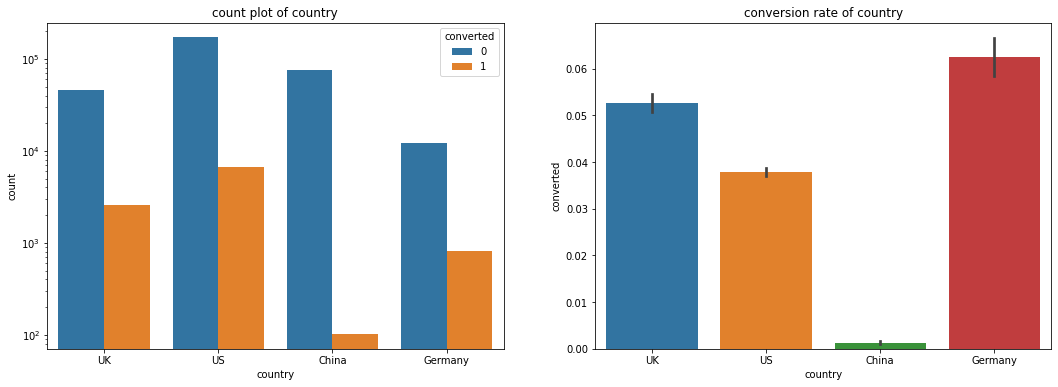

In [ ]:
#country
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.countplot(x=conv['country'],hue=conv['converted'],data=conv,ax=ax[0])
ax[0].set_title('count plot of country')
ax[0].set_yscale('log')
sns.barplot(x=conv['country'],y=conv['converted'],data=conv,ax=ax[1])
ax[1].set_title('conversion rate of country')
plt.show()

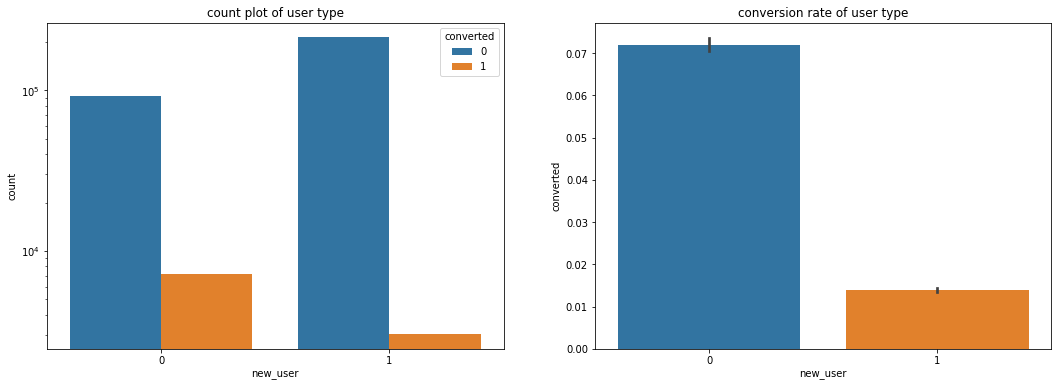

In [ ]:
#new_user
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.countplot(x=conv['new_user'],hue=conv['converted'],data=conv,ax=ax[0])
ax[0].set_title('count plot of user type')
ax[0].set_yscale('log')
sns.barplot(x=conv['new_user'],y=conv['converted'],data=conv,ax=ax[1])
ax[1].set_title('conversion rate of user type')
plt.show()

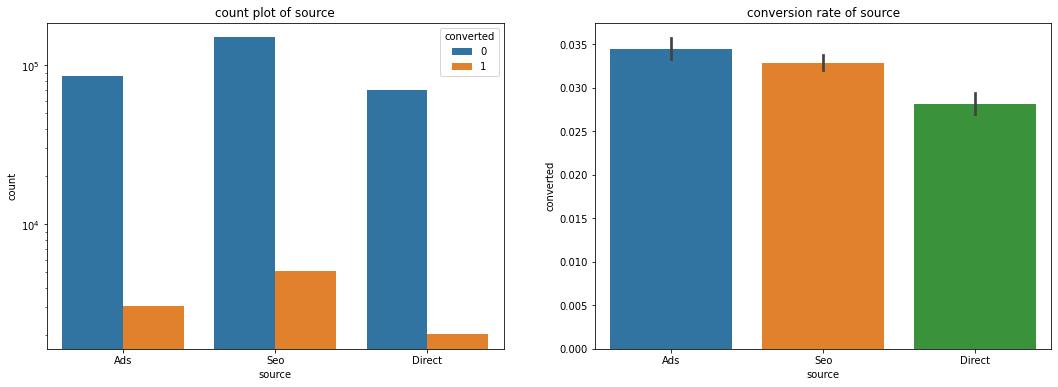

In [ ]:
#source
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.countplot(x=conv['source'],hue=conv['converted'],data=conv,ax=ax[0])
ax[0].set_title('count plot of source')
ax[0].set_yscale('log')
sns.barplot(x=conv['source'],y=conv['converted'],data=conv,ax=ax[1])
ax[1].set_title('conversion rate of source')
plt.show()

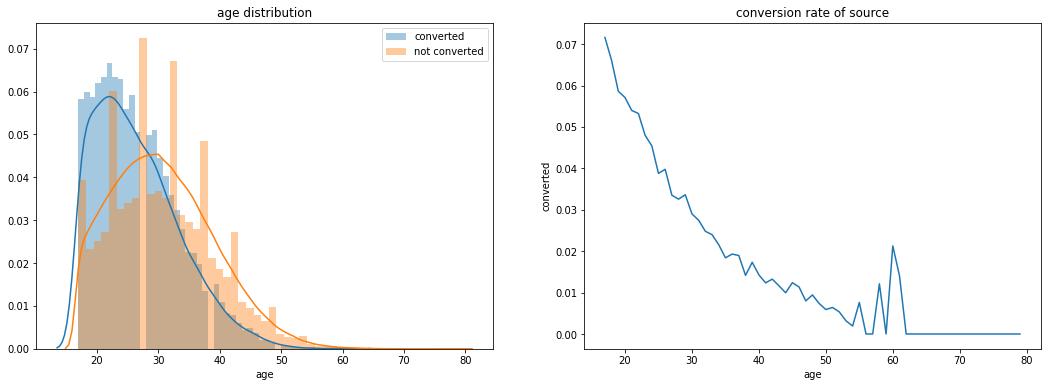

In [ ]:
#age
conv_group_age=conv['converted'].groupby(conv['age']).mean().reset_index()
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.distplot(conv[conv['converted']==1]['age'],label='converted',ax=ax[0])
sns.distplot(conv[conv['converted']==0]['age'],label='not converted',ax=ax[0])
ax[0].set_title('age distribution')
ax[0].legend()
sns.lineplot(x=conv_group_age['age'],y=conv_group_age['converted'],data=conv_group_age,ax=ax[1])
ax[1].set_title('conversion rate of source')
plt.show()

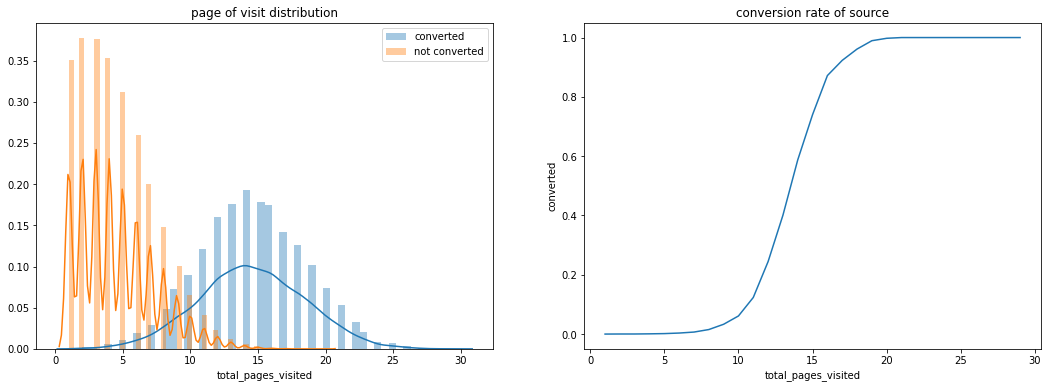

In [ ]:
#age
conv_group_visit=conv['converted'].groupby(conv['total_pages_visited']).mean().reset_index()
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.distplot(conv[conv['converted']==1]['total_pages_visited'],label='converted',ax=ax[0])
sns.distplot(conv[conv['converted']==0]['total_pages_visited'],label='not converted',ax=ax[0])
ax[0].set_title('page of visit distribution')
ax[0].legend()
sns.lineplot(x=conv_group_visit['total_pages_visited'],y=conv_group_visit['converted'],data=conv_group_age,ax=ax[1])
ax[1].set_title('conversion rate of source')
plt.show()

Machine Learning:
1. Desicion tree to show detailed rules
2. Random forest to show variable importance

In [ ]:
#get dummy before using decision tree
conv_dummy=pd.get_dummies(conv)
conv_dummy.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


   age  new_user  total_pages_visited  ...  source_Ads  source_Direct  source_Seo
0   25         1                    1  ...           1              0           0
1   23         1                    5  ...           0              0           1
2   28         1                    4  ...           0              0           1
3   39         1                    5  ...           0              0           1
4   30         1                    6  ...           0              0           1

[5 rows x 10 columns]


[Text(167.4, 199.32, 'X[2] <= 12.5\ngini = 0.062\nsamples = 252958\nvalue = [244795, 8163]'),
 Text(83.7, 163.07999999999998, 'X[2] <= 10.5\ngini = 0.02\nsamples = 245048\nvalue = [242572, 2476]'),
 Text(41.85, 126.83999999999999, 'X[2] <= 8.5\ngini = 0.01\nsamples = 237866\nvalue = [236649, 1217]'),
 Text(20.925, 90.6, 'X[2] <= 6.5\ngini = 0.005\nsamples = 221676\nvalue = [221170, 506]'),
 Text(10.4625, 54.359999999999985, 'X[2] <= 5.5\ngini = 0.002\nsamples = 188812\nvalue = [188630, 182]'),
 Text(5.23125, 18.119999999999976, 'gini = 0.001\nsamples = 164562\nvalue = [164472, 90]'),
 Text(15.693750000000001, 18.119999999999976, 'gini = 0.008\nsamples = 24250\nvalue = [24158, 92]'),
 Text(31.387500000000003, 54.359999999999985, 'X[1] <= 0.5\ngini = 0.02\nsamples = 32864\nvalue = [32540, 324]'),
 Text(26.15625, 18.119999999999976, 'gini = 0.045\nsamples = 10171\nvalue = [9939, 232]'),
 Text(36.61875, 18.119999999999976, 'gini = 0.008\nsamples = 22693\nvalue = [22601, 92]'),
 Text(62.775

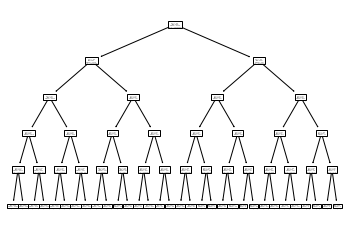

In [ ]:
x=pd.concat([conv_dummy.iloc[:,:3],conv_dummy.iloc[:,4:]],axis=1)
print(x.head())
y=conv_dummy.iloc[:,3]
x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)
clf=tree.DecisionTreeClassifier(max_depth=5)
clf=clf.fit(x_train,y_train)
tree.plot_tree(clf)

In [ ]:
# the accuracy of decision tree model is high, so we can trusrt and use the conversion rate under its prediction 
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.985246679316888


In [ ]:
pred_conv_rate = sum(i==1 for i in y_pred)/len(y_pred)
pred_conv_rate

0.028399746995572423

In [ ]:
actual_conv_rate=sum(i==1 for i in y_test)/len(y_test)
actual_conv_rate

0.03217900063251107

In [ ]:
r=tree.export_text(clf,feature_names=list(x_train))
print(r)

|--- total_pages_visited <= 12.50
|   |--- total_pages_visited <= 10.50
|   |   |--- total_pages_visited <= 8.50
|   |   |   |--- total_pages_visited <= 6.50
|   |   |   |   |--- total_pages_visited <= 5.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- total_pages_visited >  5.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- total_pages_visited >  6.50
|   |   |   |   |--- new_user <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- new_user >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- total_pages_visited >  8.50
|   |   |   |--- new_user <= 0.50
|   |   |   |   |--- country_China <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- country_China >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- new_user >  0.50
|   |   |   |   |--- country_China <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- country_China >  0.50
|   |   |   |   |   |--- class: 0
|   |--- total_pages_visited >  10.50
|   |   |--- new_user <= 0.50
| 

In [ ]:
y_train_name=y_train.map({0:'not converted',1:'converted'})
y_train.unique()
y_train_name.unique()
list(x_train)

['age',
 'new_user',
 'total_pages_visited',
 'country_China',
 'country_Germany',
 'country_UK',
 'country_US',
 'source_Ads',
 'source_Direct',
 'source_Seo']

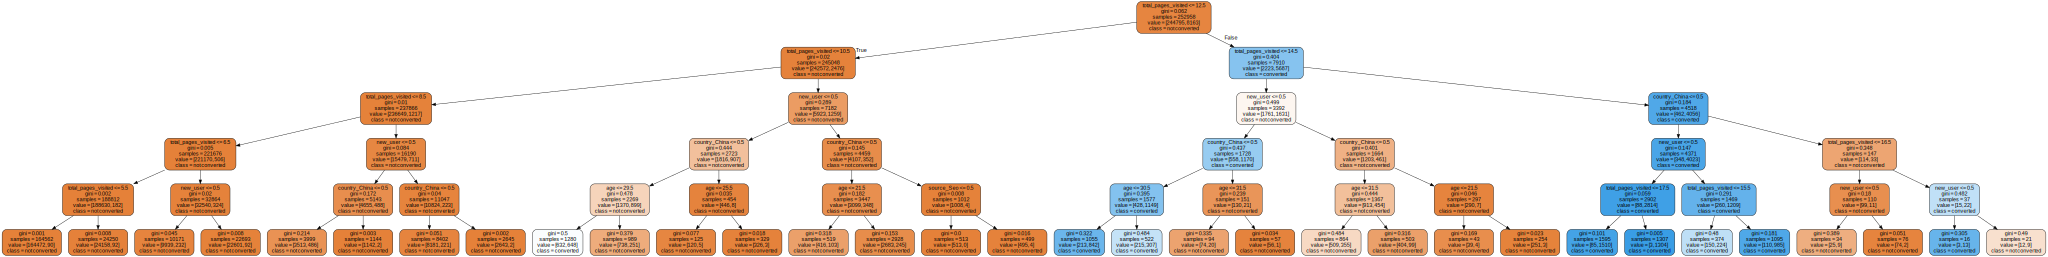

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                       feature_names=list(x_train),
                       class_names=y_train_name.unique(),
                      filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
clf.feature_importances_

array([1.45137886e-02, 5.77581059e-02, 8.84857439e-01, 4.28674361e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.23095596e-06])

In [ ]:
#random forest
rfc=RandomForestClassifier(max_depth=5)
rfc=rfc.fit(x_train,y_train)

In [ ]:
y_rpred=rfc.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_rpred))

Accuracy: 0.9855945604048071


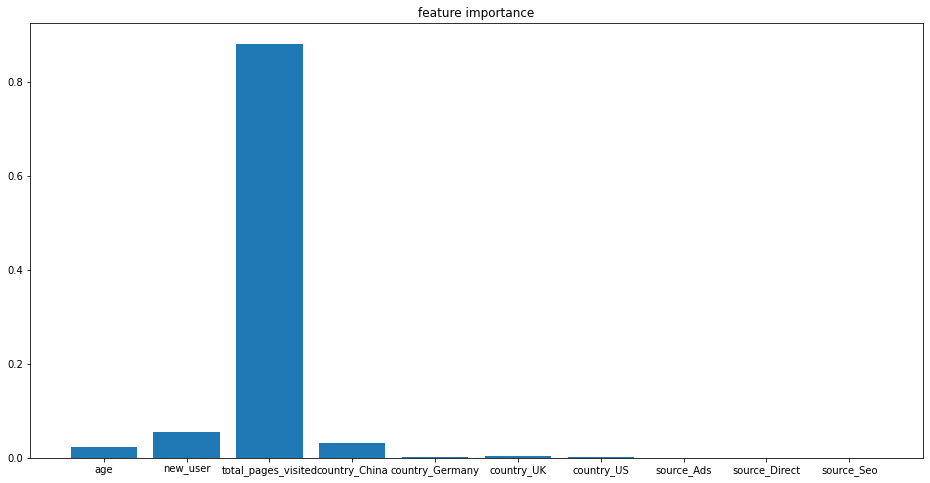

In [ ]:
importance=rfc.feature_importances_
plt.figure(figsize=(16,8))
plt.title('feature importance')
plt.bar(list(x_train),importance)
plt.show()


In [ ]:
# use h2o cluster to handle importance disappear problem with dummy in sklearn tree
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdbf4spbg
  JVM stdout: /tmp/tmpdbf4spbg/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdbf4spbg/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_yidr1y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
h2o_conv=H2OFrame(conv)

h2o_conv['new_user'] = h2o_conv['new_user'].asfactor()
h2o_conv['converted'] = h2o_conv['converted'].asfactor()

h2o_conv.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [ ]:
strat_split=h2o_conv['converted'].stratified_split(test_frac=0.25)
trainh2o=h2o_conv[strat_split=='train']
testh2o=h2o_conv[strat_split=='test']

feature=['country','age','new_user','source','total_pages_visited']
target='converted'

drf Model Build progress: |███████████████████████████████████████████████| 100%


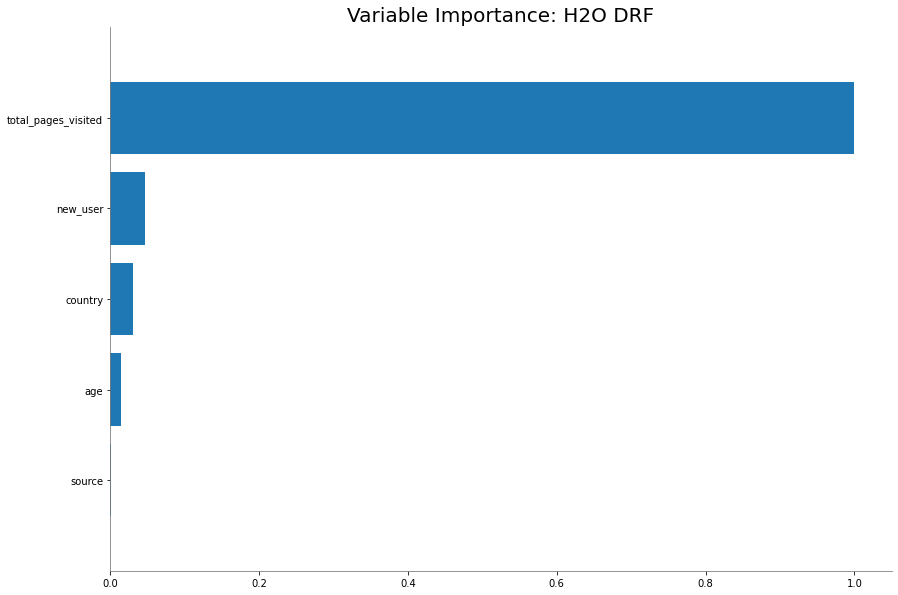

In [ ]:
modelh2o=H2ORandomForestEstimator(max_depth=5)
modelh2o.train(x=feature,y=target,training_frame=trainh2o)
modelh2o.varimp_plot()

In [ ]:
#make prediction
trainh2o_actual=trainh2o.as_data_frame()['converted'].values
testh2o_actual=testh2o.as_data_frame()['converted'].values
trainh2o_pred=modelh2o.predict(trainh2o).as_data_frame()['predict'].values
testh2o_pred=modelh2o.predict(testh2o).as_data_frame()['predict'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Classification report
print(classification_report(y_true=testh2o_actual, y_pred=(testh2o_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     76500
           1       0.79      0.74      0.76      2550

    accuracy                           0.99     79050
   macro avg       0.89      0.87      0.88     79050
weighted avg       0.98      0.99      0.98     79050



In [ ]:
# roc_curve: True positive rate and false positive rate
train_fpr,train_tpr,_=roc_curve(trainh2o_actual,trainh2o_pred)
test_fpr,test_tpr,_=roc_curve(testh2o_actual,testh2o_pred)
train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

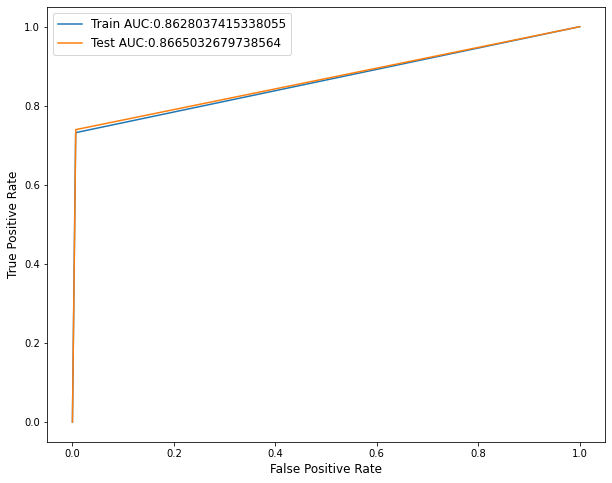

In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(train_fpr,train_tpr,label='Train AUC:'+str(train_auc))
ax.plot(test_fpr,test_tpr,label='Test AUC:'+str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/model/model_base.py:1359: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


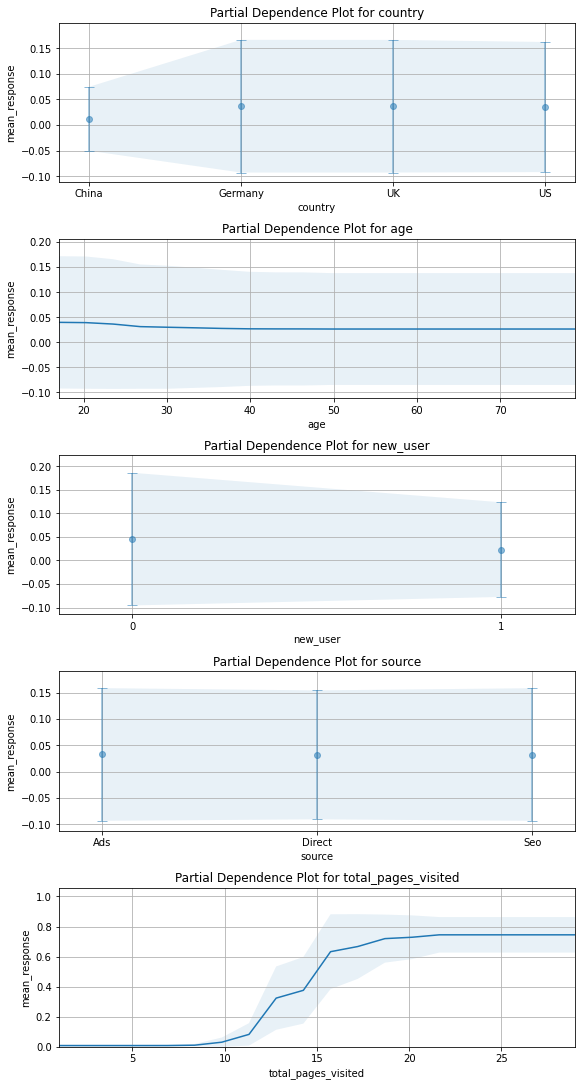

In [ ]:
#partial plot show analysis for individual variables
_=modelh2o.partial_plot(trainh2o,cols=feature,figsize=(8,15))